In [1]:
import numpy as np
np.random.seed(1)

# grAdapt
import grAdapt
from grAdapt.space.datatype import Float, Integer
from grAdapt.optimizer import AMSGrad, Adam, AMSGradBisection
from grAdapt.surrogate import GPRSlidingWindow, NoModel, NoGradient
from grAdapt.models import Sequential

# sklearn
# Import datasets, classifiers and performance metrics
from sklearn.metrics import log_loss
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# plot
import matplotlib.pyplot as plt

## 1. Load NIST Dataset

In [2]:
import os
plot_path = 'plots/'
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

In [3]:
# The digits dataset
digits = datasets.load_digits()

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

## 2. Fit SVM

In [4]:
# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001, probability=True)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [5]:
classifier.score(X_test, y_test)

0.9688542825361512

## 3. Display a test image which has been rightfully classified

### 3.1 Setting target image

In [6]:
target_idx = 1

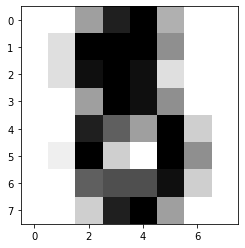

In [7]:
plt.imshow(X_test[target_idx].reshape(8, 8), cmap=plt.cm.binary)

In [8]:
y_test[target_idx]

8

In [9]:
classifier.predict(X_test[target_idx].reshape(1, -1)) == y_test[target_idx]

array([ True])

### 3.2 Setting target label

In [10]:
np.argmax(classifier.predict_log_proba(X_test[target_idx].reshape(1, -1)))

8

In [11]:
target_label = np.argsort(np.max(classifier.predict_proba(X_test[target_idx].reshape(1, -1)), axis=0))[-2]

In [12]:
target_label

6

## 4. Goal

We aim to perturbate the image above such that is will be missclassified. We have two objectives: Target the image to another label and secondly minimize the norm of the pertubation. We have to set bounds to our objective such that the created image is a valid image.

The image dataset has been normalized to 0-16. We now have to constrain the domain.

### 4.1 Define Black-Box

In [13]:
def categorical_distance(x1, x2):
    if x1 == x2:
        return 0
    else:
        return 1

In [14]:
def adversarial_examples(perturbation):
    
    perturbated_image = (X_test[target_idx] + perturbation).reshape(1, -1)
    
    pred_label_perturbated = classifier.predict(perturbated_image)
    pred_label = classifier.predict(X_test[target_idx].reshape(1, -1))
    
    # distance for categorical attributes
    categorical_loss = 1 - categorical_distance(pred_label_perturbated, pred_label)
    # minimal perturbation
    perturbation_loss = np.linalg.norm(perturbation)/len(perturbation)
    
    return categorical_loss + perturbation_loss

def adversarial_examples(perturbation):
    
    # @ Intriguing properties of neural networks
    # authors: Szegedy et al.
    
    perturbated_image = (X_test[target_idx] + perturbation).reshape(1, -1)
    
    #print(perturbated_image)
    loss = classifier.predict_proba(perturbated_image).T

    loss_target = -loss[target_label][0]
    
    perturbation_loss = np.linalg.norm(perturbation)/len(perturbation)
    
    # print(loss_target + perturbation_loss)
    
    return loss_target + perturbation_loss

In [15]:
upper_bounds = (16*np.ones(X_test[target_idx].shape[0]) - X_test[target_idx])#//(1.5)
bounds = [Float(0, x) for x in upper_bounds]

### 4.2 grAdapt

Using NoGradient accelerates the training process when dealing with high dimensional optimization problems (64 dimension). Only the escape functions are used to obtain the next point. The best point is used as the mean and surrounding points are then evaluated.

In [16]:
surrogate = NoGradient()
model = Sequential(surrogate=surrogate)
res = model.minimize(adversarial_examples, bounds, 1000)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Sampling 488 random points.
Random function evaluations. This might take a while.


 50%|███████████████████████████████████████▎                                       | 498/1000 [00:00<00:10, 49.49it/s]

Finding optimum...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 53.22it/s]


#### 4.2.1 Plot Loss

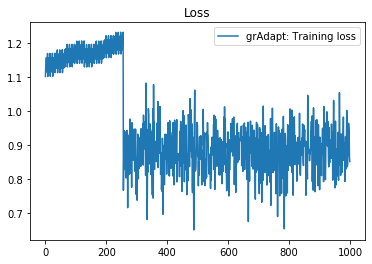

In [17]:
plt.title('Loss')
plt.plot(res['y'], label='grAdapt: Training loss')
plt.legend(loc='upper right')
#plt.yscale('log')
plt.show()

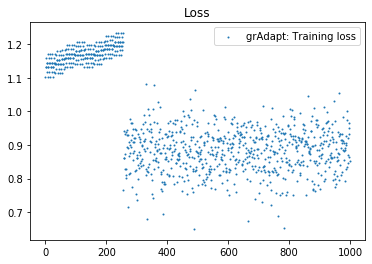

In [18]:
plt.title('Loss')
plt.scatter(np.arange(len(res['y'])), res['y'], label='grAdapt: Training loss', s=1)
plt.legend(loc='upper right')
#plt.yscale('log')
plt.show()

#### 4.2.2 Plot original and perturbated image

In [19]:
perturbated_image = np.array(res['x_sol'] + X_test[target_idx], dtype=np.float)

In [20]:
perturbated_image

array([10.10295317, 11.06627373,  9.50828183, 15.79936204, 16.        ,
        8.06983377, 13.34087368,  0.75599536, 13.8831645 ,  5.84894769,
       16.        , 16.        , 16.        , 13.40904937,  9.34010695,
        7.65299042,  0.78716236,  4.36732084, 15.41282851, 16.        ,
       15.61118407,  7.56033923,  3.96215791,  0.28894917,  7.07960706,
        1.82761043, 13.41907142, 16.        , 15.16640827, 15.91079037,
        0.53334226,  1.1492587 ,  3.39058725,  4.8019171 , 14.85576387,
       12.38698467,  7.00625095, 16.        , 10.82856914,  6.58083215,
        0.50696359,  9.42939951, 16.        ,  3.57587223, 12.54030908,
       16.        ,  9.43056512,  0.79244196,  7.19171498,  3.81386942,
       13.19315218, 14.42361413, 12.45208666, 15.10713616,  9.36784442,
        0.29716886,  1.41718457,  0.60762766, 14.57820358, 15.55820307,
       16.        ,  7.70034357,  0.46417529,  2.5108875 ])

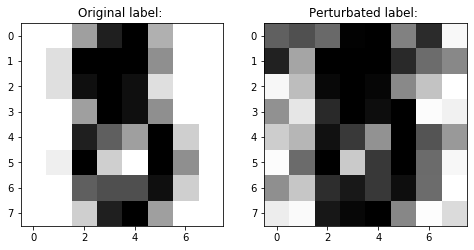

In [21]:
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 1
img = [X_test[target_idx], perturbated_image]
labels = ['Original label: '+str(), 'Perturbated label: '+str()]
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i, title=labels[i-1]+str())
    plt.imshow(img[i-1].reshape(8, 8), cmap=plt.cm.binary)
plt.show()

In [22]:
classifier.predict(perturbated_image.reshape(1, -1))

array([5])

In [23]:
classifier.predict(perturbated_image.reshape(1, -1)) != classifier.predict(X_test[target_idx].reshape(1, -1))

array([ True])

The perturbated has indeed been wrongly classified.

### 4.3 BFGS with scipy

In [24]:
import scipy

In [25]:
x0 = grAdapt.utils.sampling.sample_points_bounds(bounds, 1, random_state=1)
res_scipy = scipy.optimize.minimize(adversarial_examples, x0, bounds=bounds)

In [26]:
res_scipy

      fun: 1.6089816968877546
 hess_inv: <64x64 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.92398319e-03, 3.32331940e-03, 3.21964677e-07, 1.74349424e-04,
       0.00000000e+00, 2.92876834e-04, 8.59334826e-04, 1.59429137e-03,
       1.83053572e-03, 2.17516005e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.27886598e-03, 1.26354482e-04, 3.09329229e-03,
       1.92529326e-03, 2.25539587e-03, 4.04787315e-05, 0.00000000e+00,
       2.30893082e-04, 3.90880661e-03, 1.44602108e-03, 3.19413385e-03,
       4.04334344e-03, 4.12739842e-03, 2.45226062e-04, 0.00000000e+00,
       4.89608354e-05, 2.27893260e-03, 4.53725946e-04, 1.94283478e-03,
       4.41936487e-03, 2.45983234e-03, 3.99003053e-04, 5.45874457e-04,
       1.97953876e-03, 0.00000000e+00, 6.85562718e-05, 3.46089823e-03,
       4.56225058e-03, 3.23603366e-03, 0.00000000e+00, 2.95867775e-03,
       4.76241269e-04, 0.00000000e+00, 2.35795827e-03, 1.35462752e-03,
       1.32768241e-03, 5.99897909e-04, 3.35065309

#### 4.3.1 Plot original and perturbated image

In [27]:
perturbated_image_scipy = np.round(res_scipy.x + X_test[target_idx])

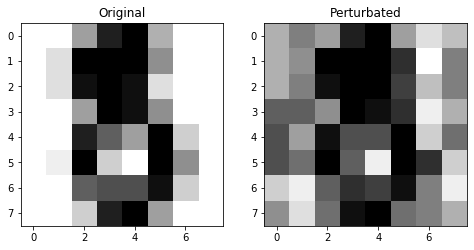

In [28]:
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 1
img = [X_test[target_idx], perturbated_image_scipy]
labels = ['Original', 'Perturbated', ]
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i, title=labels[i-1])
    plt.imshow(img[i-1].reshape(8, 8), cmap=plt.cm.binary)
plt.show()

In [29]:
classifier.predict(perturbated_image_scipy.reshape(1, -1))

array([8])

In [30]:
res_scipy.fun

1.6089816968877546

## 5. Conclusion

In this optimization formulation, BFGS struggles to find an adversarial example whereas grAdapt is able to perturbate the target image to be misclassified.